<a href="https://colab.research.google.com/github/benlau6/transformers-jax/blob/main/transformers_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers

We show how to implement transformers.
Based on sec 10.7 of http://d2l.ai/chapter_attention-mechanisms/transformer.html and https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/transformers_torch.ipynb

In [336]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import matplotlib_inline.backend_inline

import math
import jax
import jax.numpy as jnp
from flax.core import freeze
import flax.linen as nn
import torch
import optax
from torch.utils import data

from typing import Sequence
import collections
import re
import random
import os
import requests
import zipfile
import hashlib
import time

!mkdir figures # for saving plots
rng_key = jax.random.PRNGKey(0)

mkdir: figures: File exists


# Layers

In [2]:
class PositionWiseFFN(nn.Module):
    ffn_num_hiddens: int
    ffn_num_outputs: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.ffn_num_hiddens)(x)
        x = nn.relu(x)
        x = nn.Dense(self.ffn_num_outputs)(x)
        return x

In [3]:
model = PositionWiseFFN(4,8)
batch = jnp.ones((2, 3, 4))
variables = model.init(rng_key, batch)
output = model.apply(variables, batch)
output.shape

(2, 3, 8)

In [4]:
class AddNorm(nn.Module):
    dropout: float
    
    @nn.compact
    def __call__(self, x, y, deterministic: bool = True):
        x = nn.Dropout(self.dropout)(y, deterministic=deterministic) + x
        x = nn.LayerNorm()(x)
        return x

In [5]:
add_norm = AddNorm(0.5) # Normalized_shape is input.size()[1:] 
batch1 = jnp.ones((2, 3, 4))
batch2 = jnp.ones((2, 3, 4))
variables = add_norm.init(rng_key, batch1, batch2, deterministic=True)
output = add_norm.apply(variables, batch1, batch2, deterministic=True)
output.shape

(2, 3, 4)

## Abstract base class


In [6]:
class EncoderDecoder(nn.Module):
    encoder: nn.Module
    decoder: nn.Module

    @nn.compact
    def __call__(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# Encoder

In [7]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    dropout: float
    
    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    @nn.compact
    def __call__(self, queries, keys, values, valid_lens=None, deterministic=True):
        d = queries.shape[-1]
        scores = queries@(keys.swapaxes(1, 2)) / jnp.sqrt(d)
        attention_weights = masked_softmax(scores, valid_lens)
        self.sow('intermediates', 'attention_weights', attention_weights)
        dropout_layer = nn.Dropout(self.dropout, deterministic=deterministic)
        return dropout_layer(attention_weights)@values

class MultiHeadAttention(nn.Module):
    num_hiddens: int
    num_heads: int
    dropout: float
    use_bias: bool = False
    
    @nn.compact
    def __call__(self, queries, keys, values, valid_lens):
        attention = DotProductAttention(self.dropout)
        W_q = nn.Dense(self.num_hiddens, use_bias=self.use_bias)
        W_k = nn.Dense(self.num_hiddens, use_bias=self.use_bias)
        W_v = nn.Dense(self.num_hiddens, use_bias=self.use_bias)
        W_o = nn.Dense(self.num_hiddens, use_bias=self.use_bias)
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(W_q(queries), self.num_heads)
        keys = transpose_qkv(W_k(keys), self.num_heads)
        values = transpose_qkv(W_v(values), self.num_heads)
        
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = jnp.repeat(valid_lens, self.num_heads, axis=0)
            
        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = attention(queries, keys, values, valid_lens)
        
        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return W_o(output_concat)

In [304]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = jnp.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.softmax(X.reshape(shape), axis=-1)

def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen), dtype=jnp.float32)[None, :] < valid_len[:, None]
    X = jnp.where(~mask, value, X)
    return X

def transpose_qkv(X, num_heads):
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape((X.shape[0], X.shape[1], num_heads, -1))

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = jnp.transpose(X, (0, 2, 1, 3))
    
    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape((-1, X.shape[2], X.shape[3]))

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`"""
    X = X.reshape((-1, num_heads, X.shape[1], X.shape[2]))
    X = jnp.transpose(X, (0, 2, 1, 3))
    return X.reshape((X.shape[0], X.shape[1], -1))

In [9]:
class PositionalEncoding(nn.Module):
    num_hiddens: int
    dropout: float
    max_len: int = 1000
    
        
    @nn.compact
    def __call__(self, X, deterministic=True):
        # Create a long enough `P`
        P = jax.numpy.zeros((1, self.max_len, self.num_hiddens))
        x = jax.numpy.arange(self.max_len, dtype=jax.numpy.float32).reshape(
            -1, 1) / jax.numpy.power(
                10000,
                jax.numpy.arange(0, self.num_hiddens, 2, dtype=jax.numpy.float32) /
                self.num_hiddens)
        P = P.at[:, :, 0::2].set(jax.numpy.sin(x))
        P = P.at[:, :, 1::2].set(jax.numpy.cos(x))
        X = X + P[:, :X.shape[1], :]
        return nn.Dropout(self.dropout)(X, deterministic=deterministic)
        
class EncoderBlock(nn.Module): 
    num_hiddens: int
    ffn_num_hiddens: int
    num_heads: int
    dropout: float
    use_bias: bool = False
    
    @nn.compact
    def __call__(self, x, valid_lens, deterministic: bool = True):
        x_ = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout, self.use_bias)(x, x, x, valid_lens)
        y = AddNorm(self.dropout)(x, x_, deterministic=deterministic)
        y_ = PositionWiseFFN(self.ffn_num_hiddens, self.num_hiddens)(y)
        return AddNorm(self.dropout)(y, y_, deterministic=deterministic)

In [10]:
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
X = jnp.ones((2, 100, 24))
valid_lens = jnp.array([3, 2])
variables = encoder_blk.init(rng_key, X, valid_lens, deterministic=True)
output = encoder_blk.apply(variables, X, valid_lens, deterministic=True)
output.shape

(2, 100, 24)

In [11]:
class TransformerEncoder(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout: int
    use_bias: bool = False
            
    @nn.compact
    def __call__(self, X, valid_lens, deterministic: bool = True):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = PositionalEncoding(self.num_hiddens, self.dropout)(
            nn.Embed(self.vocab_size, self.num_hiddens)(X) * jnp.sqrt(self.num_hiddens)
        )

        for i in range(self.num_layers):
            X = EncoderBlock(
                self.num_hiddens,
                self.ffn_num_hiddens,
                self.num_heads,
                self.dropout,
                self.use_bias)(X, valid_lens)
        return X

The shape of the transformer encoder output is (batch size, number of time steps, num_hiddens).

In [12]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
batch = jnp.ones((2, 100), dtype=jnp.int32)
variables = encoder.init(rng_key, batch, valid_lens)
output = encoder.apply(variables, batch, valid_lens)
output.shape

(2, 100, 24)

# Decoder

In [271]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    num_hiddens: int
    ffn_num_hiddens: int
    num_heads: int
    dropout: float
    i: int
    training: bool = True

    @nn.compact
    def __call__(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = jnp.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = jnp.tile(jnp.arange(1, num_steps + 1), (batch_size, 1))
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout)(
            X, key_values, key_values, dec_valid_lens)
        Y = AddNorm(self.dropout)(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout)(
            Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = AddNorm(self.dropout)(Y, Y2)
        return AddNorm(self.dropout)(
            Z, PositionWiseFFN(self.ffn_num_hiddens, self.num_hiddens)(Z)), state

In [272]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
X = jnp.ones((2, 100, 24))
variables = encoder_blk.init(rng_key, X, valid_lens, deterministic=True)
output = encoder_blk.apply(variables, X, valid_lens, deterministic=True)
state = [output, valid_lens, [None]]

variables = decoder_blk.init(rng_key, X, state)
output = decoder_blk.apply(variables, X, state)
output[0].shape

(2, 100, 24)

In [296]:
class TransformerDecoder(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout: float
    use_bias: bool = False
    training: bool = True

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    @nn.compact
    def __call__(self, X, state):        
        X = PositionalEncoding(self.num_hiddens, self.dropout)(
            nn.Embed(self.vocab_size, self.num_hiddens)(X) * jnp.sqrt(self.num_hiddens)
        )
        
        for i in range(self.num_layers):
            X, state = DecoderBlock(
                self.num_hiddens,
                self.ffn_num_hiddens,
                self.num_heads,
                self.dropout,
                i,
                self.training)(X, state)
        return nn.Dense(self.vocab_size, use_bias=self.use_bias)(X), state

# Full model


In [18]:
# Required functions for downloading data

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [19]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target


In [20]:
class Vocab:  
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [21]:
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = reduce_sum(astype(array != vocab['<pad>'], torch.int32), 1)
    return array, valid_len

In [22]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))
    
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

# Data

We use a english-french dataset. See [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb#scrollTo=yDmK1xQ9T4IY) for details.

In [23]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

In [297]:
num_hiddens, num_layers, dropout = 32, 2, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

encoder = TransformerEncoder(len(src_vocab), num_hiddens, 
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), num_hiddens,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

# Training

In [329]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [26]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def grad_clipping(grads, theta):
    """Clip the gradient."""
    def grad_update(grads):
        return jax.tree_map(lambda g: g*theta/norm, grads)

    norm = jnp.sqrt(sum(jax.tree_util.tree_leaves(jax.tree_map(
        lambda x: jnp.sum(x**2), grads))))
    grads = jax.lax.cond(norm>theta, grad_update, lambda g: g, grads)
    return grads

In [27]:
@jax.jit
def loss(pred, label, valid_len):
    y_one_hot = jax.nn.one_hot(label, num_classes=pred.shape[-1])
    unweighted_loss = optax.softmax_cross_entropy(pred, y_one_hot)
    
    weights = jnp.ones_like(label)
    weights = sequence_mask(weights, valid_len)
    weighted_loss = jnp.mean(unweighted_loss * weights, axis=1)
    return weighted_loss

In [28]:
def train_step(apply_fn, params, X, dec_input, X_valid_len, Y, Y_valid_len):
    def loss_fn(params, X, dec_input, X_valid_len, Y, Y_valid_len):
        Y_hat, dec_state = apply_fn(params, X, dec_input, X_valid_len)
        return loss(Y_hat, Y, Y_valid_len).sum()
    
    grad_fn = jax.value_and_grad(loss_fn)
    l, grads = grad_fn(params, X, dec_input, X_valid_len, Y, Y_valid_len)
    grads = grad_clipping(grads, 1)
    return l, grads

In [29]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab):
    """Train a model for sequence to sequence."""
    optimizer = optax.adam(learning_rate=lr)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    apply_fn = jax.tree_util.Partial(net.apply)
    initialized = False
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for i, batch in enumerate(data_iter):
            X, X_valid_len, Y, Y_valid_len = [jnp.array(x) for x in batch]
            bos = jnp.array([tgt_vocab['<bos>']] * Y.shape[0]).reshape(-1, 1)
            dec_input = jnp.concatenate([bos, Y[:, :-1]], 1)  # Teacher forcing
            
            if not initialized:
                params = net.init(rng_key, X, dec_input, X_valid_len)
                opt_state = optimizer.init(params)
                initialized = True

            l, grads = train_step(apply_fn, params, X, dec_input, 
                                              X_valid_len, Y, Y_valid_len)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            
            num_tokens = Y_valid_len.sum()
            metric.add(l, num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {jax.devices()}')
    return params

loss 0.019, 271.3 tokens/sec on [CpuDevice(id=0)]


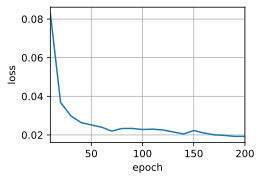

In [30]:
lr, num_epochs = 0.005, 200
params = train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab)

# Evaluation

In [317]:
def get_sub_module_params(params, sub_module_name):
    sub_params = params.unfreeze()
    sub_params['params'] = sub_params['params'][sub_module_name]
    sub_params = freeze(sub_params)
    return sub_params

def get_enc_attention_weights(state):
    attention_weights = []
    for _, val in state["intermediates"].items():
        attention_weights.append(val['MultiHeadAttention_0']['DotProductAttention_0']["attention_weights"][0])
    return jnp.array(attention_weights)

def get_dec_attention_weights(state):
    num_blks = len(state["intermediates"])
    attention_weights = [[None] * num_blks for _ in range(2)]
    for i, (_, val) in enumerate(state["intermediates"].items()):
        attention_weights[0][i] = val['MultiHeadAttention_0']['DotProductAttention_0']["attention_weights"][0]
        attention_weights[1][i] = val['MultiHeadAttention_1']['DotProductAttention_0']["attention_weights"][0]
    return attention_weights

In [318]:
def predict_seq2seq(net, params, src_sentence, src_vocab, tgt_vocab, num_steps,
                    save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.decoder.training = False
    
    # Separate trained params from net for encoder and decoder
    enc_params = get_sub_module_params(params, 'encoder')
    dec_params = get_sub_module_params(params, 'decoder')
    
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = jnp.array([len(src_tokens)])
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = jnp.expand_dims(
        jnp.array(src_tokens, dtype=jnp.int32), axis=0)
    enc_outputs, enc_intermediates = net.encoder.apply(
        enc_params, enc_X, enc_valid_len,
        capture_intermediates=lambda mdl, method_name: method_name == "attention_weights")
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = jnp.expand_dims(
        jnp.array([tgt_vocab['<bos>']], dtype=jnp.int32), axis=1)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        (Y, dec_state), dec_intermediates = net.decoder.apply(
            dec_params, dec_X, dec_state,
            capture_intermediates=lambda mdl, method_name: method_name == "attention_weights")
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(axis=2)
        pred = dec_X.squeeze(axis=0).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights = get_dec_attention_weights(dec_intermediates)
            attention_weight_seq.append(attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq, enc_intermediates

In [319]:
def bleu(pred_seq, label_seq, k):  
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [320]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq, enc_intermediates = predict_seq2seq(
        net, params, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est tombé est tombé est tombé est tombé est,  bleu 0.258
i'm home . => je suis chez moi .,  bleu 1.000


# Visualization of attention heatmaps

We visualize the attention heatmaps for the last (english, french) pair, where the input has length 3 and the output has length 5.

The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs).


In [321]:
attention_weights = get_attention_weights(enc_intermediates)
enc_attention_weights = jnp.concatenate(attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

(2, 4, 10, 10)

Encoder self-attention for each of the 2 encoder blocks.
The input has length 4, so all keys are 0 after that.

In [330]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

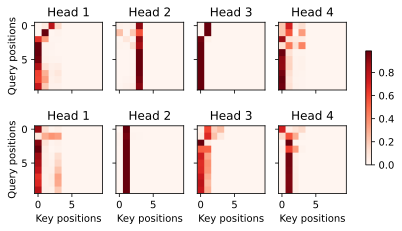

In [337]:
show_heatmaps(enc_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

Next we visualize decoder attention heatmaps.

In [338]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

In [339]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = jnp.array(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    jnp.transpose(dec_attention_weights, (1, 2, 3, 0, 4))
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

((2, 4, 6, 10), (2, 4, 6, 10))

Decoder self-attention.

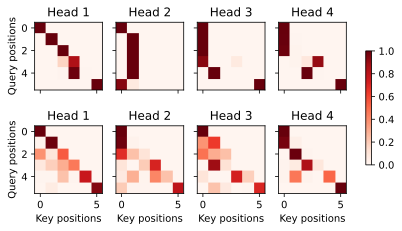

In [340]:
# Plus one to include the beginning-of-sequence token
show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Decoder encoder-attention.

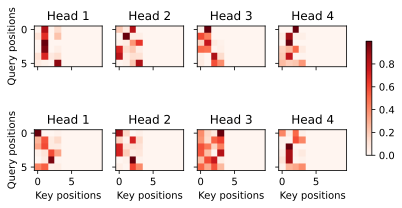

In [341]:
show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))